In [2]:
# ============================================================================
#  Import Libraries and Setup
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.datasets as datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from pathlib import Path
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:

# ============================================================================
# Configuration
# ============================================================================
CONFIG = {
    "seed": 42,
    "img_size": 224,
    "model_name": "convnext_tiny",  # More modern and powerful
    "num_classes": 4, # 'glioma', 'meningioma', 'notumor', 'pituitary'
    "batch_size": 32,
    "num_epochs": 25,
    "learning_rate": 1e-4,
    "weight_decay": 1e-6,
    "min_lr": 1e-7,
}

# Set seed for reproducibility
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])



In [4]:
# ============================================================================
# Advanced Data Augmentation (Albumentations)
# ============================================================================
train_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Custom Dataset to apply Albumentations
class AlbumentationsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = np.array(image)
            image = self.transform(image=image)['image']
        return image, label



/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-590010730.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
/tmp/ipython-input-590010730.py:14: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),


In [5]:
# ============================================================================
# Dataset and DataLoader Setup
# ============================================================================
# **IMPORTANT**: Make sure this path is correct for your environment
data_path = Path("/content/drive/MyDrive/CMAPSSData/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented")

# Create the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_path)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset_split, val_dataset_split = random_split(full_dataset, [train_size, val_size])

# Create instances of AlbumentationsDataset for train and validation
train_dataset = AlbumentationsDataset(train_dataset_split, transform=train_transforms)
val_dataset = AlbumentationsDataset(val_dataset_split, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
print(f"Classes: {full_dataset.classes}")


Training samples: 4803, Validation samples: 1201
Classes: ['512Glioma', '512Meningioma', '512Normal', '512Pituitary']


In [ ]:
# ============================================================================
# Model Selection
# ============================================================================
model = timm.create_model(CONFIG['model_name'], pretrained=True, num_classes=CONFIG['num_classes'])
model = model.to(device)


In [ ]:
# ============================================================================
# Training Loop with Enhancements
# ============================================================================
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, min_lr=CONFIG['min_lr'])
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(CONFIG['num_epochs']):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']} [Train]")
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_pbar.set_postfix(loss=running_loss/total_train, acc=100.*correct_train/total_train)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']} [Val]")
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_pbar.set_postfix(loss=val_loss/total_val, acc=100.*correct_val/total_val)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / len(val_loader.dataset)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Save the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_brain_tumor_model.pth')
        print("Model saved as best_brain_tumor_model.pth")

    scheduler.step(epoch_val_loss)



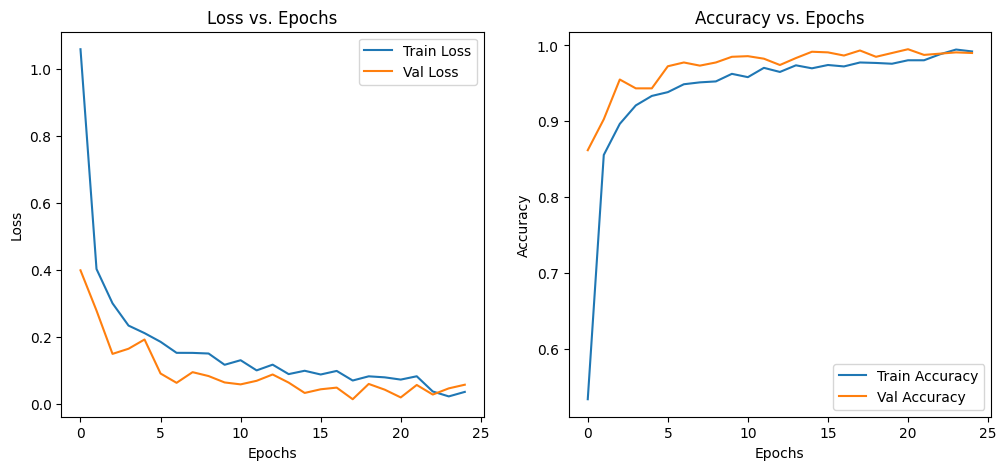


Training completed! Model saved as 'best_brain_tumor_model.pth'
You can now use this model for inference on new brain MRI images.


In [8]:
# ============================================================================
# Plot Training History
# ============================================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print("\nTraining completed! Model saved as 'best_brain_tumor_model.pth'")
print("You can now use this model for inference on new brain MRI images.")

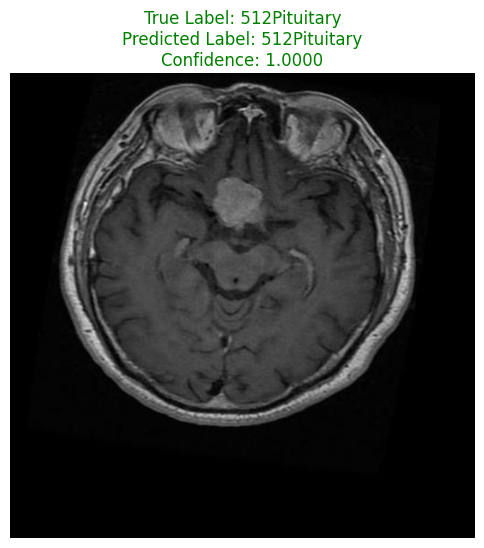


--- Generating Confusion Matrix for Validation Set ---


Calculating Predictions: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


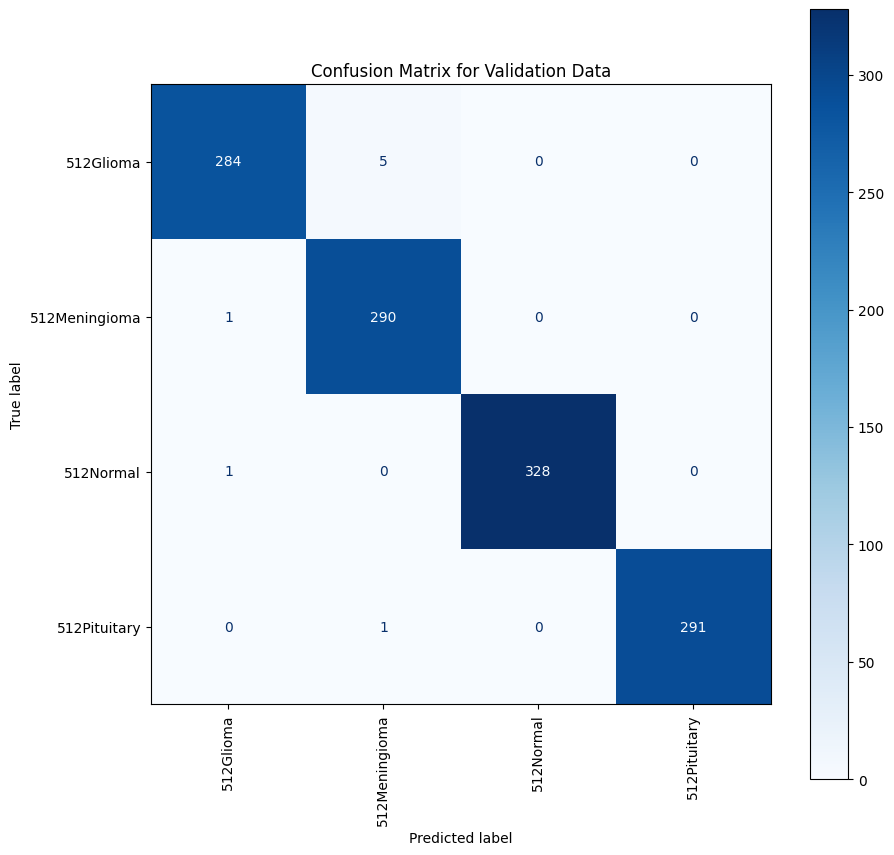

In [9]:
# ============================================================================
# Results for Presentation
# ============================================================================
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Load the best model
# Re-initialize the model architecture
model = timm.create_model(CONFIG['model_name'], pretrained=False, num_classes=CONFIG['num_classes'])
model = model.to(device)

# Load the saved weights
model.load_state_dict(torch.load('best_brain_tumor_model.pth', map_location=device))
model.eval() # Set the model to evaluation mode

# --- Get Class Names ---
class_names = full_dataset.classes

# 2. Function to predict a single image
def predict_single_image(image_path, model, transforms, device, class_names):
    """Predicts the class for a single image and returns the image, prediction, and confidence."""
    # Open the image
    img = Image.open(image_path).convert("RGB")

    # Preprocess the image
    image_np = np.array(img)
    transformed = transforms(image=image_np)
    image_tensor = transformed['image'].unsqueeze(0).to(device) # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)

    predicted_class = class_names[predicted_idx.item()]

    return img, predicted_class, confidence.item()

# 3. Select a random image from the validation set for demonstration
# Get the file paths from the validation split
val_indices = val_dataset_split.indices
val_filepaths = [full_dataset.samples[i] for i in val_indices]
random_image_path, true_label_idx = random.choice(val_filepaths)
true_label = class_names[true_label_idx]

# 4. Make and display the prediction
predicted_img, predicted_label, confidence = predict_single_image(
    random_image_path,
    model,
    val_transforms, # Use validation transforms for consistency
    device,
    class_names
)

# Display the result
plt.figure(figsize=(6, 7))
plt.imshow(predicted_img)
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}\nConfidence: {confidence:.4f}",
          color=("green" if true_label == predicted_label else "red"))
plt.axis('off')
plt.show()

# 5. Generate and Plot Confusion Matrix for the entire validation set
print("\n--- Generating Confusion Matrix for Validation Set ---")
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Calculating Predictions"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for Validation Data")
plt.show()